In [ ]:
import warnings
warnings.filterwarnings('ignore')

# !unzip "/content/drive/MyDrive/Academics/Final Year Project/Final Year Project Code/Train Videos.zip" -d "/content/Dataset/"

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE_TRAINING = 100
IMAGE_RESIZE = (240, 320)

train_data_generator = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_data_generator.flow_from_directory(
    '/content/Dataset', 
    target_size=IMAGE_RESIZE, 
    batch_size=BATCH_SIZE_TRAINING, 
    class_mode='binary'
)

Found 11413 images belonging to 2 classes.


In [ ]:
print(f'train_gen.class_indices: {train_generator.class_indices}')

train_gen.class_indices: {'0': 0, '1': 1}


In [ ]:
division = {1:4034, 0:7379}
length = 11413

def balancedClassWeight(n_samples: int, n_samples_with_class: dict) -> dict:
    
    toRet = {}
    n_classes=len(n_samples_with_class.keys())
    
    keys = n_samples_with_class.keys()
    
    for item in keys:
        toRet[item] = (n_samples/(n_classes*n_samples_with_class[item]))
        
    return toRet

class_weight = balancedClassWeight(length, division)

print(f'class weights: {class_weight}')

class weights: {1: 1.4146008924144768, 0: 0.7733432714459954}


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model


baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
    layer.trainable = False

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])


from tensorflow.python.keras.callbacks import EarlyStopping
cb_early_stopper = EarlyStopping(monitor = 'loss', patience = 4)

In [ ]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = length//BATCH_SIZE_TRAINING

fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    class_weight=class_weight,
    epochs = NUM_EPOCHS,
    callbacks=[cb_early_stopper]
)

Epoch 1/10
114/114 [==============================] - 213s 2s/step - loss: 0.2793 - accuracy: 0.8769
Epoch 2/10
114/114 [==============================] - 181s 2s/step - loss: 0.0543 - accuracy: 0.9842
Epoch 3/10
114/114 [==============================] - 181s 2s/step - loss: 0.0258 - accuracy: 0.9937
Epoch 4/10
114/114 [==============================] - 181s 2s/step - loss: 0.0180 - accuracy: 0.9943
Epoch 5/10
114/114 [==============================] - 181s 2s/step - loss: 0.0116 - accuracy: 0.9975
Epoch 6/10
114/114 [==============================] - 181s 2s/step - loss: 0.0070 - accuracy: 0.9982
Epoch 7/10
114/114 [==============================] - 181s 2s/step - loss: 0.0071 - accuracy: 0.9976
Epoch 8/10
114/114 [==============================] - 181s 2s/step - loss: 0.0046 - accuracy: 0.9987
Epoch 9/10
114/114 [==============================] - 181s 2s/step - loss: 0.0023 - accuracy: 0.9997
Epoch 10/10
114/114 [==============================] - 181s 2s/step - loss: 0.0021 - accura

In [ ]:
model_save_path = '/content/drive/MyDrive/Academics/Final Year Project/Final Year Project Code/models/model_x-y-21.h5'
model.save(model_save_path)

In [ ]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy'])


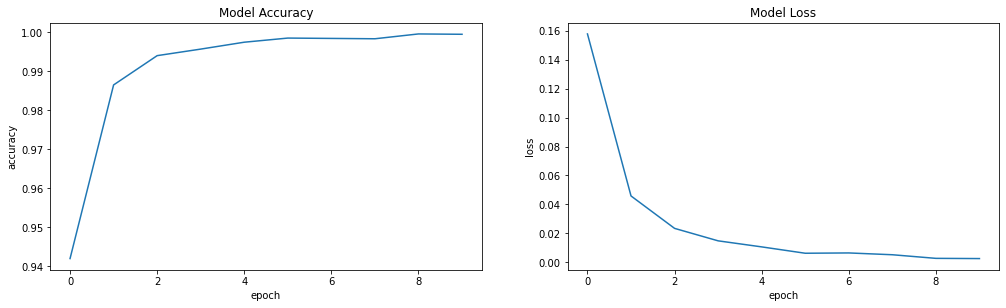

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize = (17,10)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])    
plt.title('Model Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.title('Model Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  

plt.show()